In [6]:
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
                model="deepseek-chat",
                temperature=0,
                api_key="sk-5bde98f731ef4869b3fb7f06ab5d9f57",
                )

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="分析员的主要隶属机构",
    )
    name: str = Field(
        description="分析员的名字"
    )
    role: str = Field(
        description="分析人员在主题背景下的作用。",
    )
    description: str = Field(
        description="描述分析员的关注重点、关切问题和动机。",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="全部的分析员名单，包括他们的角色和所属机构。",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

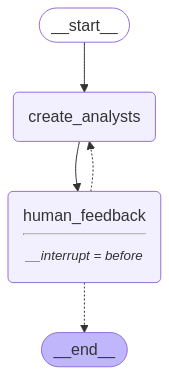

In [8]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""你的任务是创建一组人工智能分析员角色。请仔细按照以下说明操作:

1. 首先，回顾研究课题:
{topic}
        
2. 检查任何编辑反馈，这些反馈可以选择性地提供，以指导分析人员的创建: 
        
{human_analyst_feedback}
    
3. 根据上述文件和/或反馈，确定最有趣的主题。
                    
4. 选取最热门的 {max_analysts} 主题。

5. 为每个主题指派一名分析师。"""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# Input
max_analysts = 3 
topic = "告诉我采用 LangGraph 作为Agent框架的好处"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 李明
Affiliation: 清华大学
Role: 人工智能研究员
Description: 专注于自然语言处理和机器学习框架的研究，关注LangGraph在Agent框架中的应用和优化。
--------------------------------------------------
Name: 王芳
Affiliation: 北京大学
Role: 数据科学家
Description: 致力于数据驱动的决策支持系统，研究LangGraph在复杂数据处理和决策分析中的优势。
--------------------------------------------------
Name: 张伟
Affiliation: 中国科学院
Role: 系统架构师
Description: 专注于分布式系统和计算框架的设计，研究LangGraph在构建高效、可扩展的Agent系统中的作用。
--------------------------------------------------


In [10]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [11]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "加入来自初创企业的人员，增加创业者的视角"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f007d3a-14e0-61a6-8002-cde7287dc6d6'}}

In [12]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: 李明
Affiliation: 清华大学
Role: 人工智能研究员
Description: 专注于自然语言处理和机器学习框架的研究，关注LangGraph在Agent框架中的应用和优化。
--------------------------------------------------
Name: 王芳
Affiliation: 北京大学
Role: 数据科学家
Description: 致力于数据驱动的决策支持系统，研究LangGraph在复杂数据处理和决策分析中的优势。
--------------------------------------------------
Name: 张伟
Affiliation: 中国科学院
Role: 系统架构师
Description: 专注于分布式系统和计算框架的设计，研究LangGraph在构建高效、可扩展的Agent系统中的作用。
--------------------------------------------------
Name: 李明
Affiliation: 清华大学
Role: 人工智能研究员
Description: 专注于自然语言处理和机器学习框架的研究，关注LangGraph在学术研究中的应用和潜力。
--------------------------------------------------
Name: 王芳
Affiliation: 阿里巴巴
Role: 技术主管
Description: 负责公司内部AI平台的开发，关注LangGraph在企业级应用中的性能和可扩展性。
--------------------------------------------------
Name: 张伟
Affiliation: 创新工场
Role: 创业者
Description: 关注LangGraph在初创企业中的应用，特别是其在快速迭代和低成本开发中的优势。
--------------------------------------------------


In [13]:
# If we are satisfied, then we simply supply no feedback
further_feedack = "分析员的信息都用中文"
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f007d40-ed70-6f1f-8004-6432d11d1205'}}

In [14]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
create_analysts
--Node--
__interrupt__


In [15]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [16]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: 李明
Affiliation: 清华大学
Role: 技术专家
Description: 专注于LangGraph的技术实现和性能优化，关注其在Agent框架中的应用潜力。
--------------------------------------------------
Name: 王芳
Affiliation: 北京大学
Role: 应用研究员
Description: 研究LangGraph在实际应用中的优势，特别是在多Agent系统中的应用。
--------------------------------------------------
Name: 张伟
Affiliation: 中国科学院
Role: 理论研究员
Description: 探讨LangGraph作为Agent框架的理论基础，分析其与其他框架的对比优势。
--------------------------------------------------


In [17]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="检索查询")

In [18]:
question_instructions = """你是一名分析员，负责采访一位专家，了解一个特定的主题。您的目标是归纳出与您的主题相关的有趣而具体的见解。
1. 有趣： 人们会觉得惊讶或不显而易见的见解。
        
2. 具体：避免泛泛而谈的见解，包括专家的具体实例。

以下是您的重点话题和一系列目标: {goals}
        
首先，用一个符合你的角色的名字介绍自己，然后提出你的问题。

继续提问，深入并完善您对主题的理解。
        
当你对自己的理解感到满意时，用以下方式完成访谈： “非常感谢你的帮助！”

记住，在整个回答过程中要保持你的性格，反映出提供给你的角色和目标。"""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

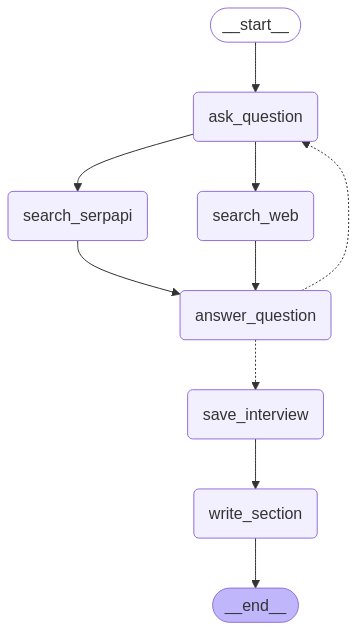

In [19]:
from langchain_community.utilities import SerpAPIWrapper  # 新增的导入
from langchain_community.tools import TavilySearchResults
import os
# 设置全局代理（推荐使用稳定的API代理服务）
os.environ["SERPAPI_API_KEY"] = "743923c35fcacfaf41c3d945e23ae1ff8f5e1eefd7f40cf10115a476f8c115ca"
os.environ["TAVILY_API_KEY"] = "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"

from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""您将得到一段分析员与专家之间的对话。

您的目标是生成一个结构良好的查询，用于与对话相关的检索/网络搜索。
        
首先，分析对话全文。

特别注意分析员提出的最后一个问题。

将这个最终问题转换成结构良好的网络搜索查询""")


def search_web(state):
    
    """ Retrieve docs from web search """
   # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    # Search
    tavily_search = TavilySearchResults(max_results=3)
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
def search_serpapi(state):
    
    """ 从Serp搜索引擎获取文档 """

    # Search
    #初始化SerAPI包装器
    serpapi = SerpAPIWrapper()
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    #执行搜索结果
    search_docs = serpapi.run(search_query.search_query)

     # Format
    formatted_search_docs = f'<Document source="SerpAPI">\n{search_docs}\n</Document>'
           
    return {"context": [formatted_search_docs]} 

answer_instructions = """你是一位专家，正在接受一位分析师的访谈。

以下是分析员关注的领域： {goals}. 
        
您的目标是回答面试官提出的问题。

要回答问题，请使用以下语境：
        
{context}

回答问题时，请遵循以下准则：
        
1.只使用上下文中提供的信息。
        
2.不要引入外部信息或作出超出上下文明确说明的假设。

3. 上下文包含每份单独文件主题的来源。

4. 在任何相关语句旁注明这些资料来源。例如，对于资料来源 1，请使用 [1]。 

5. 在答案底部按顺序列出资料来源。[1] 来源 1，[2] 来源 2 等。
        
6. 如果来源是: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' 只列出以下内容即可: 
        
[1] assistant/docs/llama3_1.pdf, 第7页
        
然后跳过括号以及引用中的文档来源前言。"""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """你是一名专业技术撰稿人。
            
您的任务是根据一组原始文件，在一份报告中编写一个简短易懂的部分。

1. 分析源文件的内容： 
- 每个源文件的名称都在文件的开头，使用 <Document 标签。
        
2. 使用标记符格式创建报告结构：
- 章节标题使用 ##
- 小节标题使用 ###
        
3. 按照此结构编写报告：
a. 标题（##标题）
b. 摘要（###标题）
c. 资料来源（###标题）

4. 4. 根据分析师的重点领域，使标题引人入胜：:
{focus}

5. 摘要部分：
- 用与分析师重点领域相关的一般背景/环境设置摘要
- 强调从访谈中收集到的见解的新颖、有趣或令人惊讶之处
- 在使用源文件时，为其创建一个编号列表
- 不要提及访谈者或专家的姓名
- 最多约 400 字
- 根据源文件中的信息，在报告中使用编号来源（如 [1]、[2]）
        
6. 在资料来源部分：
- 包括报告中使用的所有资料来源
- 提供相关网站或具体文件路径的完整链接
- 用换行符分隔每个来源。在 Markdown 中，每行末尾使用两个空格来创建换行符。
- 它看起来像

#### 来源
[1] 链接或文件名称
[2] 链接或文件名称

7. 请务必合并来源。例如，这是不正确的：
[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

不应有多余的来源。应该是
[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. 最后审查：
- 确保报告符合规定的结构
- 报告标题前不包含序言
- 检查是否遵循了所有指导原则"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_serpapi", search_serpapi)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_serpapi")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_serpapi", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [20]:
# Pick one analyst
analysts[0]

Analyst(affiliation='清华大学', name='李明', role='技术专家', description='专注于LangGraph的技术实现和性能优化，关注其在Agent框架中的应用潜力。')

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph的技术实现与性能优化

### 摘要
LangGraph是一个用于构建基于大型语言模型（LLM）的有状态、多参与者应用程序的库，特别适合创建复杂的代理和多代理工作流。其核心优势包括循环支持、细粒度控制和内置持久性，这些特性使其在Agent框架中具有广泛的应用潜力[1][2]。

LangGraph的循环支持使其能够定义涉及循环的流程，这对于大多数代理架构来说是必不可少的。这种能力使LangGraph有别于基于有向无环图（DAG）的解决方案，后者不直接支持循环[1]。此外，LangGraph提供了对应用程序流程和状态的细粒度控制，这对于创建可靠、可预测的代理至关重要[2]。

内置持久性功能使代理能够记住过去的交互并使用这些信息来指导未来的决策，支持高级的人机循环，使代理能够与人类用户进行更自然、更有效的交互[1]。LangGraph可以与LangChain生态系统无缝集成，也可以作为独立框架使用，以利用其独特的优势和功能[1]。

LangGraph的应用场景广泛，包括对话代理和聊天机器人、推荐系统、游戏开发等[1]。例如，它可以用于构建复杂的对话代理和聊天机器人，能够处理多轮对话、上下文理解和个性化交互[1]。此外，LangGraph还可以用于构建个性化的推荐系统，根据用户的兴趣、历史行为和上下文信息提供相关的建议[1]。

### 资料来源
[1] https://www.cnblogs.com/smartloli/p/18276355  
[2] https://agent.csdn.net/67d8c8f81056564ee2463218.html

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

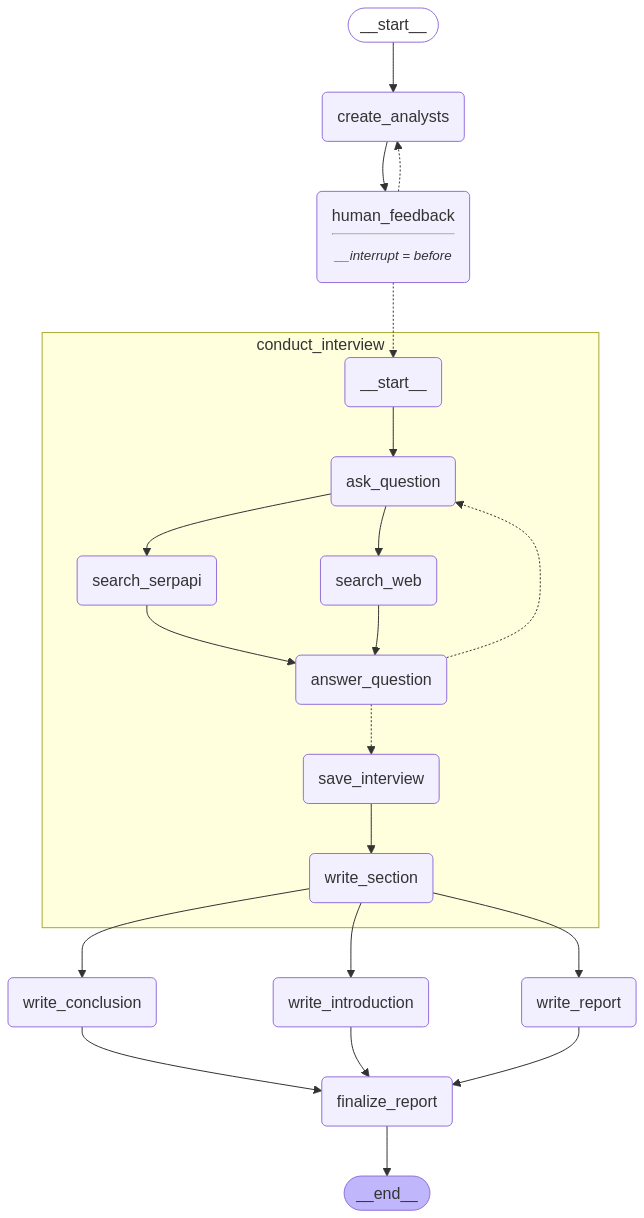

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ 这是 “映射 ”步骤，我们使用发送 API 运行每个访谈子图"""    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """您是一名技术撰稿人，正在就这一总体主题{topic}撰写报告:    
您有一个分析员团队。每位分析员都做了两件事： :

1. 他们就特定子课题采访了一位专家。
2. 将他们的发现写成备忘录。

您的任务： 

1. 您将从您的分析员那里得到一批备忘录。
2. 仔细思考每份备忘录中的见解。
3. 将这些内容整合成一个清晰的总体摘要，将所有备忘录中的中心思想串联起来。
4. 将每份备忘录中的中心观点总结成一个有凝聚力的单一叙述。

报告格式:
 
1. 使用markdown的格式。
2. 报告不包含前言。
3. 不使用小标题
4. 用一个标题作为报告的开头： ## 见解
5. 不要在报告中提及任何分析师的姓名。
6. 保留备忘录中的任何引文，引文将用括号标注，如 [1] 或 [2]。
7. 创建一份最终的、合并的来源清单，并添加到 “来源 ”部分，标题为 “### 来源”。
8.按顺序列出资料来源，不要重复。


[1] 来源 1
[2] 来源 2

以下是您的分析师提供的备忘录，您可以据此编写报告：

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """你是一名技术撰稿人，正在完成一份关于{topic}的报告。


您将得到报告的所有部分。

您的任务是写出简洁有力的引言或结论部分。

用户会指示您是写引言还是结论。

两个部分都不要包含前言。

目标字数在 100 字左右，清晰地预览（导言）或复述（结论）报告的所有部分。

使用标记符格式。

对于引言，请创建一个引人注目的标题，并使用 # 标题。

在引言中，使用 ## 引言作为章节标题。

结论部分，使用 ### 结语作为标题。

以下是写作时需要思考的部分： {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
# Inputs
max_analysts = 3 

topic = "告诉我采用 LangGraph 作为Agent框架的好处"

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 李明
Affiliation: 清华大学
Role: 人工智能研究员
Description: 专注于自然语言处理和机器学习框架的研究，关注LangGraph在Agent框架中的应用和优化。
--------------------------------------------------
Name: 王芳
Affiliation: 北京大学
Role: 数据科学家
Description: 致力于数据驱动的决策支持系统，研究LangGraph在复杂数据处理和决策分析中的优势。
--------------------------------------------------
Name: 张伟
Affiliation: 中国科学院
Role: 系统架构师
Description: 专注于分布式系统和计算框架的设计，研究LangGraph在构建高效、可扩展的Agent系统中的作用。
--------------------------------------------------


In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "加入来自初创企业的人员，增加创业者的视角"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f007d51-b758-6822-8002-67027f8c769d'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 李明
Affiliation: 清华大学
Role: 人工智能研究员
Description: 专注于自然语言处理和机器学习框架的研究，关注LangGraph在Agent框架中的应用和优化。
--------------------------------------------------
Name: 王芳
Affiliation: 北京大学
Role: 数据科学家
Description: 致力于数据驱动的决策支持系统，研究LangGraph在复杂数据处理和决策分析中的优势。
--------------------------------------------------
Name: 张伟
Affiliation: 中国科学院
Role: 系统架构师
Description: 专注于分布式系统和计算框架的设计，研究LangGraph在构建高效、可扩展的Agent系统中的作用。
--------------------------------------------------
Name: 李明
Affiliation: 清华大学
Role: AI研究员
Description: 专注于AI框架的性能优化和可扩展性研究，关注LangGraph在大型项目中的应用。
--------------------------------------------------
Name: 王芳
Affiliation: 阿里巴巴
Role: 技术主管
Description: 负责AI技术在电商平台的应用，关注LangGraph如何提升业务效率和用户体验。
--------------------------------------------------
Name: 张伟
Affiliation: 初创企业
Role: 创业者
Description: 致力于将AI技术应用于新兴市场，关注LangGraph在快速迭代和低成本开发中的优势。
--------------------------------------------------


In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f007d53-4593-6ea4-8004-ada8444412e3'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# LangGraph：构建智能Agent的未来框架

## 引言  
在人工智能技术快速发展的今天，构建高效、灵活且可扩展的智能Agent系统成为开发者面临的核心挑战。LangGraph作为一种新兴的AI框架，凭借其独特的循环图结构、多代理支持以及与LangChain生态系统的无缝集成，正在为大型AI项目提供全新的解决方案。本报告将深入探讨LangGraph在性能优化、可扩展性、电商平台应用以及新兴市场快速迭代中的显著优势。通过分析其技术特性和实际应用案例，我们将揭示LangGraph如何为开发者提供更强大的工具，以应对复杂AI系统的构建需求，并推动智能Agent技术的未来发展。

---

## 见解

LangGraph 作为一种新兴的 AI 框架，凭借其独特的设计理念和技术优势，正在多个领域展现出强大的应用潜力。其核心特性包括循环图结构、多代理支持、细粒度工作流控制以及与 LangChain 生态系统的无缝集成，这些特性使其在大型项目、电商平台以及新兴市场中表现出卓越的性能优化、可扩展性和开发效率。

在大型 AI 项目中，LangGraph 的灵活架构和循环图结构使其能够高效处理复杂节点逻辑场景，同时为开发者提供了对决策过程的更大控制权 [1][2]。其与 LangChain 生态系统的无缝集成以及作为独立库使用的灵活性，进一步增强了其在构建动态、多代理系统中的应用价值 [3][4]。

在电商平台中，LangGraph 的细粒度控制和内置持久性功能使其能够灵活定义任务节点，支持并行、条件分支和循环等复杂工作流 [5]。这种能力使其在构建智能客服系统、个性化推荐系统等场景中表现出色，显著提升了业务效率和用户体验 [6][7]。此外，LangGraph 的持久性功能使代理能够记住过去的交互，从而在复杂环境中做出更明智的决策 [8]。

对于新兴市场，LangGraph 的低代码特性和快速迭代能力使其成为低成本开发的理想选择。其可视化工具和图形化开发环境（如 LangGraph Studio）显著降低了开发门槛，使开发者能够通过拖拽方式快速搭建复杂逻辑流 [9][10]。同时，LangGraph 引入的概率图模型和分散式决策优化了系统性能，实验表明其在减少延迟和冗余通信方面具有显著优势 [11]。

综上所述，LangGraph 凭借其灵活性、可扩展性和高效性，正在成为构建复杂 AI 应用的强大工具。无论是大型项目、电商平台还是新兴市场，LangGraph 都能提供卓越的技术支持，推动 AI 技术的快速迭代和广泛应用。

### 来源
[1] https://agent.csdn.net/67d7f48e1056564ee246296e.html  
[2] https://agent.csdn.net/67d7f42f1056564ee246288d.html  
[3] https://blog.csdn.net/csdn1561168266/article/details/139337156  
[4] https://www.cnblogs.com/ExMan/p/18728921  
[5] https://zhuanlan.zhihu.com/p/29287827352  
[6] https://www.cnblogs.com/smartloli/p/18276355  
[7] https://zhuanlan.zhihu.com/p/18555531485  
[8] https://www.sohu.com/a/843288725_120583109  
[9] https://cloud.tencent.com/developer/article/2443465  
[10] https://blog.csdn.net/2401_85325726/article/details/141676561  
[11] SerpAPI

---

### 结语

LangGraph 作为一款创新的 AI 框架，凭借其循环图结构、多代理支持和细粒度控制能力，在大型 AI 项目、电商平台以及新兴市场中展现了卓越的性能优化与可扩展性。其与 LangChain 生态系统的无缝集成、灵活的开发模式以及低成本快速迭代的优势，使其成为构建复杂智能应用的理想选择。无论是提升业务效率、优化用户体验，还是支持新兴市场的技术需求，LangGraph 都证明了其作为下一代 AI 框架的潜力与价值。